<a href="https://colab.research.google.com/github/sjbaek12/sjbaek12.github.io/blob/master/RNN_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**순환신경망**

순환신경망에서는 뉴런을 셀이라고 부른다. 아래의 예는 한개의 순환층으로 구성된 RNN이다. 이번 예는 저수준의 API로 실행한 사례이다.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb

빈출 단어 중 top 20개를 제외하고 분석에 사용될 전체 단어수를 100개로 한정

In [2]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)

17465344/17464789 [==============================] - 0s 0us/step


In [ ]:
print(x_train_all[0])

[2, 2, 22, 2, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 2, 2, 36, 2, 2, 25, 2, 43, 2, 2, 50, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 2, 2, 38, 2, 2, 2, 2, 50, 2, 2, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 22, 71, 87, 2, 2, 43, 2, 38, 76, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 2, 2, 2, 62, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 66, 2, 33, 2, 2, 2, 2, 38, 2, 2, 25, 2, 51, 36, 2, 48, 25, 2, 33, 2, 22, 2, 2, 28, 77, 52, 2, 2, 2, 2, 82, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 2, 2, 2, 2, 2, 2, 88, 2, 2, 2, 2, 98, 32, 2, 56, 26, 2, 2, 2, 2, 2, 2, 2, 22, 21, 2, 2, 26, 2, 2, 2, 30, 2, 2, 51, 36, 28, 2, 92, 25, 2, 2, 2, 65, 2, 38, 2, 88, 2, 2, 2, 2, 2, 2, 2, 2, 32, 2, 2, 2, 2, 2, 32]


In [3]:
for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]

print(x_train_all[0])

[22, 43, 65, 66, 36, 25, 43, 50, 35, 39, 38, 50, 22, 22, 71, 87, 43, 38, 76, 22, 62, 66, 33, 38, 25, 51, 36, 48, 25, 33, 22, 28, 77, 52, 82, 36, 71, 43, 26, 46, 88, 98, 32, 56, 26, 22, 21, 26, 30, 51, 36, 28, 92, 25, 65, 38, 88, 32, 32]


In [4]:
word_to_index = imdb.get_word_index()

word_to_index['movie']

1646592/1641221 [==============================] - 0s 0us/step


17

In [5]:
index_to_word = {word_to_index[k]: k for k in word_to_index}

for w in x_train_all[0]:
    print(index_to_word[w-3], end=' ') # 3 이상 부터 영어단어 이다

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

In [ ]:
print(x_train_all.shape, y_train_all.shape)

(25000,) (25000,)


In [ ]:
print(len(x_train_all[0]), len(x_train_all[1]))

59 32


In [ ]:
print(y_train_all[:10])

[1 0 0 1 0 0 1 0 1 0]


In [6]:
np.random.seed(42)
random_index = np.random.permutation(25000)

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

샘플만다 문장의 길이가 다르므로 최대 100개 단어만 포함되도록 전처리 한다

In [7]:
from tensorflow.keras.preprocessing import sequence

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [ ]:
print(x_train_seq.shape, x_val_seq.shape)

(20000, 100) (5000, 100)


(100, 20000)


sequence.pad_sequence 함수는 단어수가 100개가 않될 때, 앞쪽부터 0으로 채워준다. **0번은 무슨 문자를 의미할까?**

In [ ]:
print(x_train_seq[1])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 54 39 27 35 35 56 27 29 80 27 27 46 23
 35 64 86 65 35 22 63 73 29 22 82 34 50 26 21 47 30 97 83 76 69 86 31 61
 49 99 85 85 26 73 81 87 53 26 53 74 26 53 62 28 21 50 44 93 22 39 34 21
 45 87 20 32]


In [8]:
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

하나의 샘플은 최대길이가 100 단어이고, 이를 onehot으로 바꾸면 (20000,100) 메트릭스 구조는 (20000, 100, 100)로 전환되고 마지막 100은 0 또는 1로만 구성되고 두번째 100은 마지막 100개의 0,1로 구성된 리스트가 100개 모여있는 구조이다.  

순환신경망에서는 타임스텝으로 전체 샘플이 하나의 타임스템 set를 구성해서 동시에 순환층의 셀로 입력된다. 이를 위해서 입력데이터의 변경이 필요하고 numpy에서는 np.swapaxes(x, 0, 1)을 사용한다. 이렇게 하면 0,1이 100개로 구성된 20000개의 샘플이 만들어 지고 (20000,100) 이후 100개의 타입스텝을 구성하는 매트릭스가 만들어 진다. (100,(20000,100)) --> (100, 20000, 100)
 

In [ ]:
x_train_onehot_seq_test = np.swapaxes(x_train_onehot, 0, 1)
print(x_train_onehot_seq_test.shape)
print(x_train_onehot_seq_test[0][1999]) # 1999번째 샘플의 0번 타입스텝 자료 이다.

(100, 20000, 100)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


**tf.transpose(x, [1,0,2])와 np.swapaxes(x, 0,1)은 같은 기능을 한다**
아래 데이터를 보면 1999번째 샘플의 첫번째 단어가 윗 칸의 결과와 동일하다는 것을 알수 있다

In [ ]:
x_train_onehot_seq_transpose = tf.transpose(x_train_onehot, [1, 0, 2])
print(x_train_onehot_seq_transpose.shape)
print(x_train_onehot_seq_transpose[0][1999])

(100, 20000, 100)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.], shape=(100,), dtype=float32)


In [ ]:
h_test = None
h_test = [tf.Variable(np.zeros((3,4)))]
print(h_test)
h_test.append([9,10])
print(h_test[-1])
h_test.append([11,20])
print(h_test[-1])

[<tf.Variable 'Variable:0' shape=(3, 4) dtype=float64, numpy=
array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])>]
[9, 10]
[11, 20]


In [ ]:
y_train1 = y_train.reshape(-1,1)
print(y_train1.shape[1])

1


**아래는 저수준의 API를 이용하여 RNN을 수행하기 위한 핵심부분이다.**

In [ ]:
def gen_batch1(x, y, batch_size = 32):
    length = len(x)
    bins = length // batch_size # 미니배치 횟수
    if length % batch_size:
      bins += 1                    # 나누어 떨어지지 않을 때
    indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = batch_size * i
      end = batch_size * (i + 1)
      yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.

orth = tf.initializers.Orthogonal()
g = tf.initializers.GlorotUniform()

n_cells = 10
n_classes = 1
n_features = 100

w1h = tf.Variable(orth((n_cells, n_cells))) # (셀 개수, 셀 개수)
w1x = tf.Variable(g((n_features, n_cells))) # (특성 개수, 셀 개수)
b1 = tf.Variable(np.zeros(n_cells), dtype=float)                # 은닉층의 크기
w2 = tf.Variable(g((n_cells, n_classes)))   # (셀 개수, 클래스 개수), 클래스는 최종 출력층의 클래스를 의미한다. 1,0으로 구분되면 1이다.
b2 = tf.Variable(np.zeros(n_classes), dtype=float)


for x_batch, y_batch in gen_batch1(x_train_onehot, y_train):
  seq = tf.transpose(x_batch, [1, 0, 2])
  h = [tf.zeros((32, n_cells))] ## np.zeros와 tf.zeros는 동일한 역할을 한다. 순환층의 순환 입력인 h.shape는 (샘플수, 셀수)이며 여기서 샘플은 배치로 들어오는 샘플 수 이다. 
  # h[-1].shape는 (32,10)이다.
  # seq.shape는 (타입스텝수, 배치샘플수, 피처의 수)이고 이를 for문으로 돌리면 모든 배치의 피처로 구성된 매트릭스를 모든 타입스템이 종료될때 까지 종료한다.
  # 요약하면 아래는 100번의 타입스템을 반복하는 form 문이다. 
  for x in seq: # x.shape=(32,100), tf.matmul(x, w1x)의 shape는 (32,10) 즉 (배치의 샘플 수, 셀수)
    z1 = tf.matmul(x, w1x) + tf.matmul(h[-1], w1h) + b1
    h1 = tf.math.tanh(z1)
    h.append(h1)
    z2 = tf.matmul(h, w2) + b2
  print(z2)
  break




tf.Tensor(
[[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.        ]
  [ 0.        ]
  [ 0.        ]]

 [[-0.1134952 ]
  [-0.1134952 ]
  [-0.1134952 ]
  ...
  [ 0.10696866]
  [-0.1134952 ]
  [-0.1134952 ]]

 [[-0.37890983]
  [-0.37890983]
  [-0.37890983]
  ...
  [-0.19381759]
  [-0.37890983]
  [-0.37890983]]

 ...

 [[ 0.20559448]
  [-0.80267304]
  [-0.83811986]
  ...
  [ 0.48204535]
  [ 0.20198806]
  [-0.23623969]]

 [[ 0.2635964 ]
  [-0.96342784]
  [-0.77399445]
  ...
  [-0.19330658]
  [ 0.39716306]
  [ 0.08583396]]

 [[ 0.05638719]
  [-0.21821207]
  [ 0.38992298]
  ...
  [-0.7803012 ]
  [-0.01133937]
  [-0.09685934]]], shape=(101, 32, 1), dtype=float32)


In [ ]:
import tensorflow as tf

In [9]:
class RecurrentNetwork():
    
    def __init__(self, n_cells=10, batch_size=32, learning_rate=0.1):
        self.n_cells = n_cells     # 셀 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1h = None            # 은닉 상태에 대한 가중치
        self.w1x = None            # 입력에 대한 가중치
        self.b1 = None             # 순환층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.h = None              # 순환층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률

    def forpass(self, x):
        self.h = [tf.zeros((x.shape[0], self.n_cells))]   # 은닉 상태를 초기화합니다. 여기가 중요하다
        
        # self.h = [np.zeros((x.shape[0], self.n_cells))]   # 은닉 상태를 초기화합니다.
        # h값은 순환층의 하나의 셀의 출렬값이다. h의 shape는 (샘플수, 셀수)로 초기화 된다.
        # 왜냐하면 타입스텝별로 전체의 샘플이 은닉층의 셀로 입력되기 때문이다. 메트릭스의 표현으로는 (100, 20000) * (20000, 셀수)
        # 배치 차원과 타임 스텝 차원을 바꿉니다.
        seq = tf.transpose(x, [1, 0, 2])
        # seq = np.swapaxes(x, 0, 1)
        # 순환 층의 선형 식을 계산합니다. 
        # seq.shape = (100, batch_size, 100) 형식이다. 즉 전체 샘플 중에서 batch로 선택된 데이터를 (타입스텝, 배치, 피쳐)로 뽑은 것이고, x는 타입스텝을 제외한(배치, 피처)이다.
        # 즉 선택된 배치의 (배치, 피쳐)를 모든 타입스템에 걸처서 for문을 돌리는 구조이다
        # 첫번째 타입스텝 input은 h로 기록되고 다음 타입스텝에 입력으로 다시 들어간다.
        # 최종적으로 마지막 타입스텝까지 처리된 후 한개의 출력증으로 들어간다. 즉 여러개의 타입스텝 자료가 순환층을 거쳐서 한개의 출력층으로 들어가는 다대일 구조이다.
        for x in seq:                       
            z1 = tf.matmul(x, self.w1x) + tf.matmul(self.h[-1], self.w1h) + self.b1
            h = tf.math.tanh(z1)                    # 활성화 함수를 적용합니다.
            self.h.append(h)                   # 역전파를 위해 은닉 상태 저장합니다.
            z2 = tf.matmul(h, self.w2) + self.b2  # 출력층의 선형 식을 계산합니다.
        return z2


    
    def sigmoid(self, z):
        #z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + tf.math.exp(-z))              # 시그모이드 계산
        return a
    
    def init_weights(self, n_features, n_classes):
        orth_init = tf.initializers.Orthogonal()
        glorot_init = tf.initializers.GlorotUniform()

        self.w1h = tf.Variable(orth_init((self.n_cells, self.n_cells))) # (셀 개수, 셀 개수)
        self.w1x = tf.Variable(glorot_init((n_features, self.n_cells))) # (특성 개수, 셀 개수)
        self.b1 = tf.Variable(np.zeros(self.n_cells), dtype=float)                # 은닉층의 크기
        self.w2 = tf.Variable(glorot_init((self.n_cells, n_classes)))   # (셀 개수, 클래스 개수)
        self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)
        
        
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        np.random.seed(42)
        self.init_weights(x.shape[2], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')  # 반복 횟수만큼 점을 찍는다.
                self.training(x_batch, y_batch)
                # 배치 손실을 기록합니다.
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            self.losses.append(np.mean(batch_losses))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)


    def get_loss(self, x, y):
        z = self.forpass(x) 
        a = self.sigmoid(z)                 # 정방향 계산을 수행합니다.
        # 손실을 계산하여 저장합니다.
        loss = tf.reduce_sum(-(y*tf.math.log(a) + (1-y)*tf.math.log(1-a)))
        return loss.numpy()


    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
 
    def training(self, x, y):
       m = len(x) # 샘플 개수를 저장합니다.
       with tf.GradientTape() as tape:
         z = self.forpass(x)       # 정방향 계산을 수행합니다.
         a = self.sigmoid(z)       # 활성화 함수를 적용합니다.
            # 손실을 계산합니다.
         loss = tf.reduce_sum(-(y*tf.math.log(a) + (1-y)*tf.math.log(1-a)))

       weights_list = [self.w1h, self.w1x, self.b1, self.w2, self.b2]
        # 가중치에 대한 그래디언트를 계산합니다. loss를 특정 weights_list에서 미분한 미분값을 grads로 저정한다.
       grads = tape.gradient(loss, weights_list)
        # 가중치를 업데이트합니다.
       self.optimizer.apply_gradients(zip(grads, weights_list))
       
 

   
    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return z > 0                 # 스텝 함수를 적용합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == y.reshape(-1, 1))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.sigmoid(z)                # 활성화 함수를 적용합니다.
        #a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        val_loss = tf.reduce_mean(-(y_val*tf.math.log(a) + (1-y_val)*tf.math.log(1-a)))
        self.val_losses.append(val_loss)

In [10]:
rn = RecurrentNetwork(n_cells=32, batch_size=32, learning_rate=0.01)

rn.fit(x_train_onehot, y_train, epochs=10, x_val=x_val_onehot, y_val=y_val)

에포크 0 .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 ..........................................................................................................................................................................................................................................................................................................................................................................

In [11]:
import matplotlib.pyplot as plt

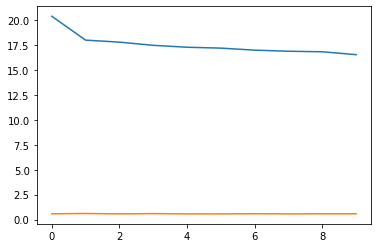

In [12]:
plt.plot(rn.losses)
plt.plot(rn.val_losses)
plt.show()

In [13]:
rn.score(x_val_onehot, y_val)

0.7024

**Sequential model로 RNN을 구현**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [ ]:
model = Sequential()

model.add(SimpleRNN(32, input_shape=(100, 100))) # one_hotcoding의 크기가 100, 타입스템의 크기가 100이다.
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                4256      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_onehot, y_train, epochs=20, batch_size=32, 
                    validation_data=(x_val_onehot, y_val))

Epoch 1/20
625/625 [==============================] - 12s 19ms/step - loss: 0.7019 - accuracy: 0.5070 - val_loss: 0.6930 - val_accuracy: 0.5304
Epoch 2/20
625/625 [==============================] - 11s 18ms/step - loss: 0.6837 - accuracy: 0.5634 - val_loss: 0.6783 - val_accuracy: 0.5762
Epoch 3/20
625/625 [==============================] - 11s 18ms/step - loss: 0.6622 - accuracy: 0.6026 - val_loss: 0.6436 - val_accuracy: 0.6250
Epoch 4/20
625/625 [==============================] - 11s 18ms/step - loss: 0.6471 - accuracy: 0.6271 - val_loss: 0.6869 - val_accuracy: 0.5442
Epoch 5/20
625/625 [==============================] - 11s 18ms/step - loss: 0.6407 - accuracy: 0.6385 - val_loss: 0.6727 - val_accuracy: 0.5960
Epoch 6/20
625/625 [==============================] - 11s 18ms/step - loss: 0.6175 - accuracy: 0.6674 - val_loss: 0.6215 - val_accuracy: 0.6550
Epoch 7/20
625/625 [==============================] - 12s 19ms/step - loss: 0.6105 - accuracy: 0.6704 - val_loss: 0.5939 - val_accuracy:

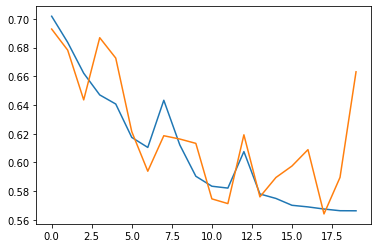

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

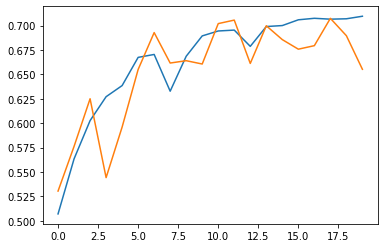

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_val_onehot, y_val, verbose=0)
print(accuracy)

0.6552000045776367
